# Searching for specific features
-----
Dec 2016.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from labm8 import fs
from labm8 import viz

import clgen
from clgen import corpus

## Experimental Setup

**Target code:**

In [2]:
# print(data[0]['data']['start_code'])
# print("// features:", data[0]['data']['start_features'])

## Experimental results

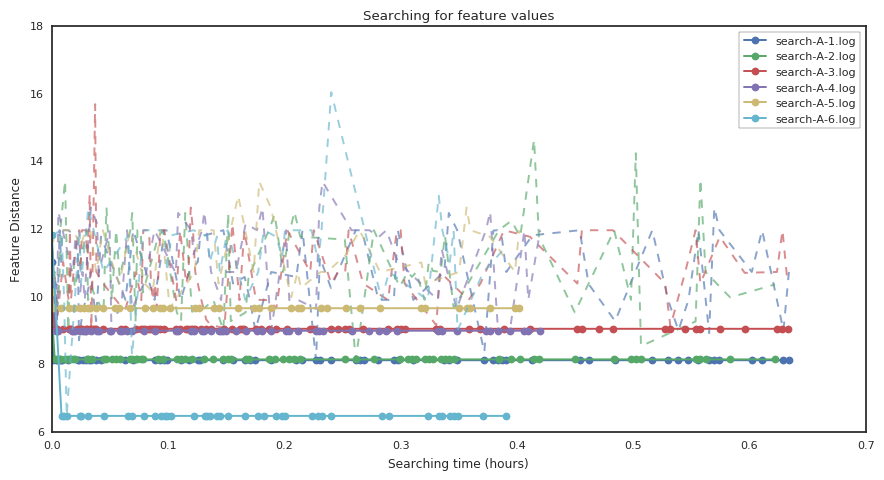

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from labm8 import viz
plt.style.use(["seaborn-white", "seaborn-paper"])

def get_distances(log):
    """ return list of best distances per step """
    
    return dates, bests

logs = [
    'search/search-A-1.log',
    'search/search-A-2.log',
    'search/search-A-3.log',
    'search/search-A-4.log',
    'search/search-A-5.log',
    'search/search-A-6.log',
]

for log in logs:
    data = clgen.load_json_file(log)
    start_time = datetime.strptime(data[0]['date'], '%Y-%m-%d %H:%M:%S')
    dates = [0]
    bests = [data[0]['data']['distance']]
    distances = [data[0]['data']['distance']]
    for entry in data:
        if entry.get("name") == "step":
            timestamp = datetime.strptime(entry['date'], '%Y-%m-%d %H:%M:%S') 
            time = (timestamp - start_time).seconds / 60 / 60
            dates.append(time)
            bests.append(entry['data']['best']['distance'])
            distances.append(entry['data']['distance'])
    
    line, = plt.plot(dates, bests, label=fs.basename(log), marker='o')
    plt.plot(dates, distances,
             alpha=.65, color=line.get_color(), linestyle='--')

ax = plt.gca()
plt.legend(loc='upper right')
ax.get_legend().set_title("")
ax.get_legend().draw_frame(True)

plt.title("Searching for feature values")
plt.xlabel("Searching time (hours)")
plt.ylabel("Feature Distance")
viz.finalise(figsize=(9, 5))

In [19]:
for log in logs:
    data = clgen.load_json_file(log)
    i = 0
    for entry in data:
        if entry.get("name") == "step":
            i += 1
            
            print("//", log, "STEP", i)
            distance = entry['data']['distance']
            best = entry['data']['best']['distance']
            diff = 1 - distance / best
            print("// distance: {:.2f} (best {:.2f}, {:.2f}%)".format(
                      distance, best, diff * 100))
            print("// features:", entry['data']['features'])
            print(entry['data']['code'])
            print()

// search/search-A-1.log STEP 1
// distance: 10.74 (best 8.13, -32.07%)
// features: 1.0, 0.0, 3.0, 0.0, 3.0, 0.0, 1.0, 0.333
__kernel void A(__global float* a, __global float* b, __global float* c) {
  size_t d = get_global_id(0);

  c[d] = a[d] + b[d];
}

// search/search-A-1.log STEP 2
// distance: 9.91 (best 8.13, -21.95%)
// features: 1.0, 1.0, 3.0, 0.0, 3.0, 0.0, 1.0, 0.333
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d)
    c[e] = a[e] + b[e];
}

// search/search-A-1.log STEP 3
// distance: 9.01 (best 8.13, -10.80%)
// features: 2.0, 1.0, 4.0, 0.0, 4.0, 0.0, 1.0, 0.5
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d)
    b[e] = a[e] + b[e] + c[e];
}

// search/search-A-1.log STEP 4
// distance: 11.97 (best 8.13, -47.25%)
// features: 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.333
__kernel void A(__global float* a, __global flo